## Profile Training and Testing Data

This notebook profiles the images from Cornell Lab's NABirds data set. The notebook will look at the distribution species observed and review the quality of the images.  

In [3]:
# CV2 doesn't install well on the rasp pi so we will try and limit the usage of that library across the analysis so as not to introduce techniques that cannot be repeated on the feeder.   
# To the end, this notebook shares a code base with the feeder using the gcs.py and image_proc.py python files from the feeder project itself.  
try:
    import cv2
except:
    !pip install opencv-contrib-python
    import cv2

In [1]:
import pandas as pd
import gcs_inventory as gcsi
import matplotlib.pyplot as plt
import gcs
from io import BytesIO
from PIL import Image
import numpy as np
import image_proc

no module auth.py found with key google_json_key for gcs, assuming this is running from within GCP project


In [2]:
# set up gcs storage for future reference throughout
archive_web_storage = gcs.Storage(bucket_name='archive_jpg_from_birdclassifier')
nabirds_web_storage = gcs.Storage(bucket_name='nabirds_filtered')

# read the list of nabird files created with gcs_inventory locally and uploaded 
# saves some $$ avoiding a full list from gcs repeatedly
df_file_name = 'nabirds-jpg-list.csv'
try: 
    df_raw = pd.read_csv(df_file_name)  # reload existing file if it exists, delete it if you want to recreate it
    print(f'Loading existing file {df_file_name}')
except:
    df_raw = gcsi.get_nabirds_jpg_images(df_file_name)  # .01 per 1000 operations so about $0.80 per run, create from scratch
    print(f'Reading images from GCS....')

df_raw.to_csv(df_file_name, index=False)
print(f'Saved jpg list as {df_file_name}....')  # this save my be redundant if the file was loaded from disk vs. recreated from the gcs listing


Loading existing file nabirds-jpg-list.csv
Saved jpg list as nabirds-jpg-list.csv....


In [4]:
### helper functions  ###

# open cv does not install well on rasp pi, adding focal quality function here instead of image_proc
# this technique would need to be manually created in the image_proc lib for the pi
def focal_quality(img: Image.Image) -> float:
    laplacain_operator = cv2.Laplacian(np.array(image_proc.grayscale(img)), cv2.CV_64F)
    return laplacain_operator.var()

In [5]:
# profile df
print(f'df shape {df_raw.shape}')
print(df_raw.columns)
# print(df_raw.to_string())

df shape (3076, 7)
Index(['Number', 'Class Name', 'Name', 'Sex', 'Juvenile', 'Class',
       'Image Name'],
      dtype='object')


### Image Review North American Birds (NABirds)

At first glance the training and testing data appears imbalanced; however, the new data has a split between male and female birds.  I think this will yield higher accuracy on the final results.  Once the gender is factored in the distribution looks balanced.  

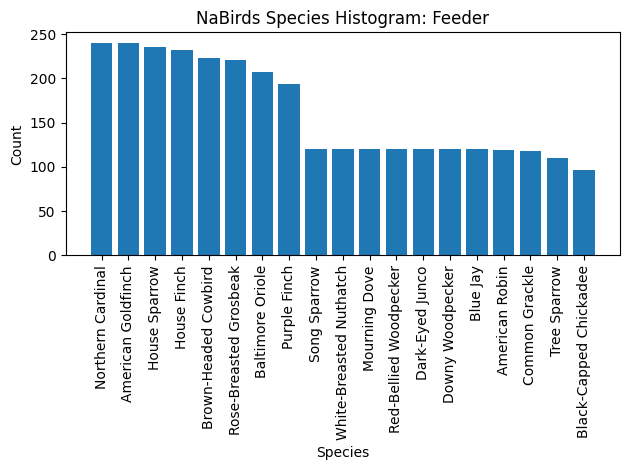

In [6]:
name_counts = df_raw['Name'].value_counts()    
filtered_data = name_counts
plt.bar(filtered_data.index, filtered_data.values) 
plt.xticks(rotation='vertical')
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('NaBirds Species Histogram: Feeder')
plt.tight_layout()
plt.show()

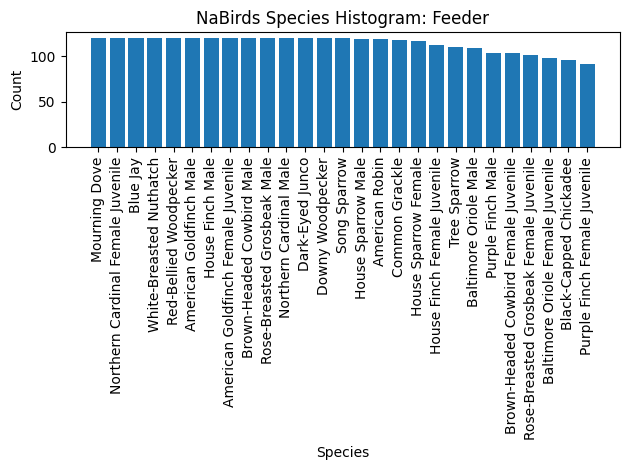

In [7]:
# plot histograms for NABirds, Name col is the matching name format from the feeder
# Class name has the Female and Male splits
name_counts = df_raw['Class Name'].value_counts()    
filtered_data = name_counts
plt.bar(filtered_data.index, filtered_data.values) 
plt.xticks(rotation='vertical')
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('NaBirds Species Histogram: Feeder')
plt.tight_layout()
plt.show()

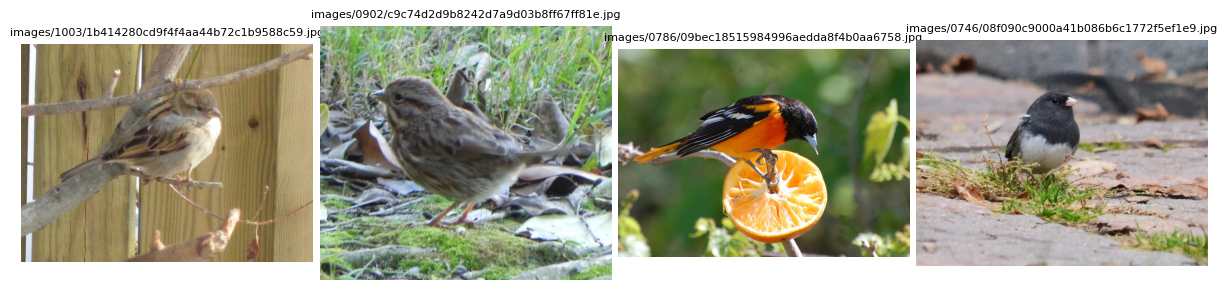

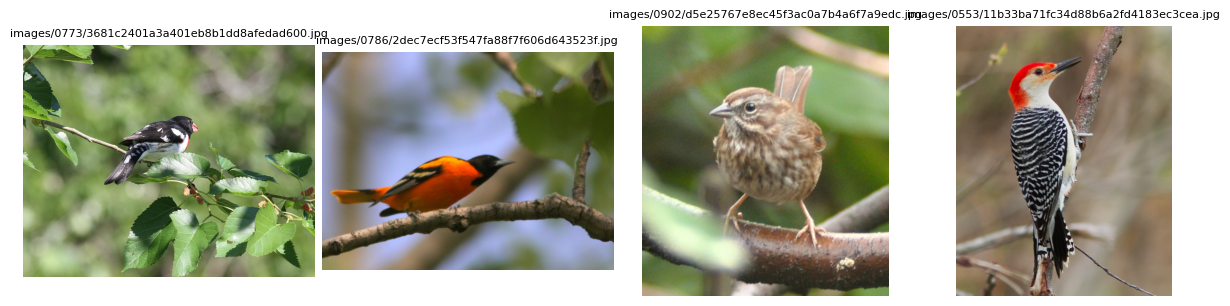

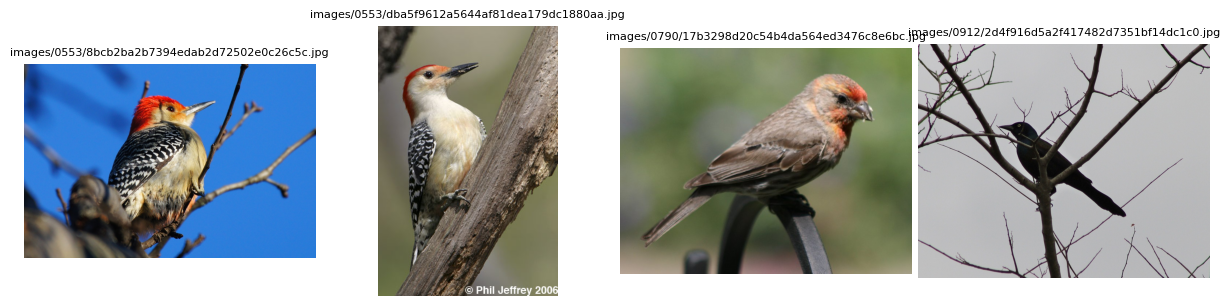

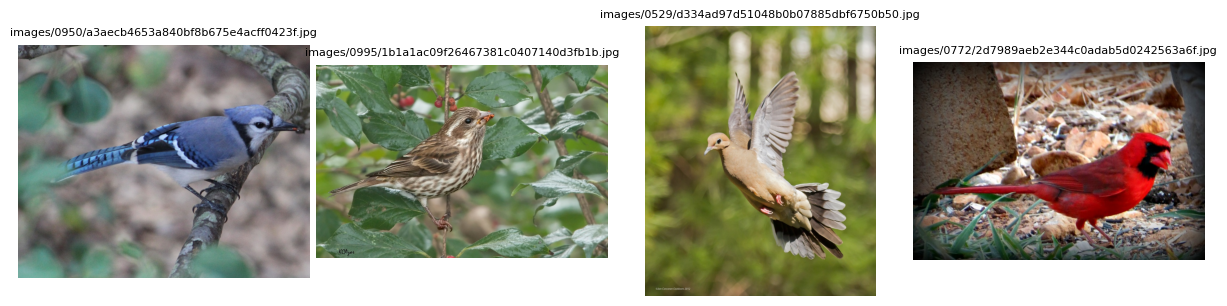

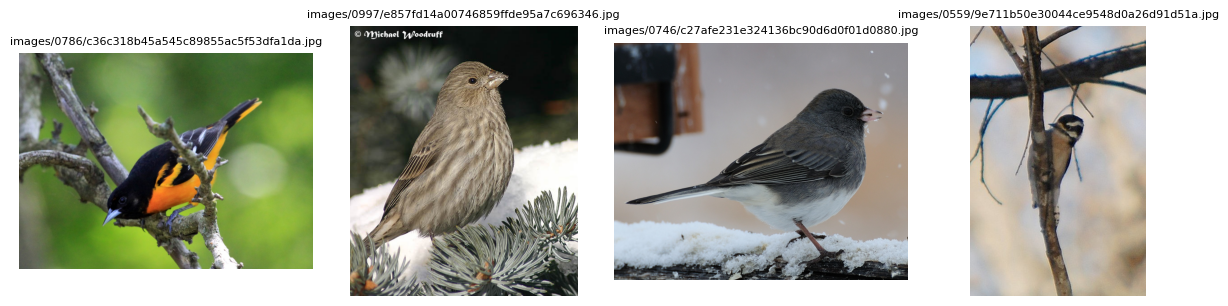

In [19]:
# print out images of n=sample size
images_per_row = 4
sample_size = 20
df_sample = df_raw.sample(n=sample_size)
num_rows = np.ceil(sample_size / images_per_row).astype(int)
for ii in range(num_rows):
    fig, axes = plt.subplots(1, images_per_row, figsize=(12, 3))  
    
    for jj in range(images_per_row):
        p_index = ii * images_per_row + jj
        if p_index < sample_size:
            img_filename = df_sample.iloc[p_index]['Image Name']
            img = nabirds_web_storage.get_img_file(img_filename)
            axes[jj].imshow(img)
            axes[jj].axis('off')
            axes[jj].set_title(img_filename, fontsize=8)
        else:
            fig.delaxes(axes[jj]) #Delete unused axes to avoid blank space

    plt.tight_layout(pad=0.5)
    plt.show()

### NaBirds Image Quality
Pertuz, S., Puig, D., & Gracia, M. (2013) compared a number of different techniques to measure focal quality. They concluded that the Laplacain operator was the best overall measure. I have an implementation of that from OpenCv in this notebook. After some experimentation it would seem that a variance of anything under 100 lack edges and is therefore low quality.

The notebook also implements measures for avg exposure. The images are converted to gray scale and than to a 2 dimensional numpy array. The values are from 0 (unexposed) to 255 (full exposure) so, np.mean can be used to calculate the average exposure. Similarly the contrast can be measured using the standard deviation function on the same numpy array. The quality determinations are not exact, but the assumptions are listed here:

Focal quality >= 100
Contrast quality between 49 and 101
Exposure quality between 99 and 151

In [8]:
# sample nabirds for analysis on the pictures themselves
# same process as feeder data
# blur or focus quality: anything under 100 is low quality
# contrast: good is between 50 and 100, < 50 lacks detail, >100 losses detail in light and dark areas
# avg exposure: < 100 is too dark > 150 is washed out
start_time = time.time()
sample_size = 500 # df_raw.shape[0] 
df_nabirds = df_raw.sample(n=sample_size, random_state=1)

df_nabirds['Image'] = df_nabirds['Image Name'].apply(nabirds_web_storage.get_img_file)
df_nabirds['Focal'] = df_nabirds['Image'].apply(focal_quality)
df_nabirds['Contrast'] = df_nabirds['Image'].apply(image_proc.contrast_quality)
df_nabirds['Exposure'] = df_nabirds['Image'].apply(image_proc.avg_exposure)
# print(df_nabirds.to_string())                            
df_nabirds['Focal Quality'] = (df_nabirds['Focal'] > 100)
df_nabirds['Contrast Quality'] = (df_nabirds['Contrast'] > 50) & (df_nabirds['Contrast'] < 100)
df_nabirds['Exposure Quality'] = (df_nabirds['Exposure'] > 100) & (df_nabirds['Exposure'] < 150)
df_nabirds['Any Quality Issue'] = ~(df_nabirds['Focal Quality'] & df_nabirds['Contrast Quality'] & df_nabirds['Exposure Quality'])
print(f'Elapsed time: {time.time() - start_time:.4f} seconds')

In [ ]:
# df_print = df_nabirds.drop(['Image Name', 'Image'], axis=1)
# print(df_print.to_string())

In [9]:
true_count = df_nabirds['Any Quality Issue'].sum()
print(true_count) 
print(sample_size)

383
500


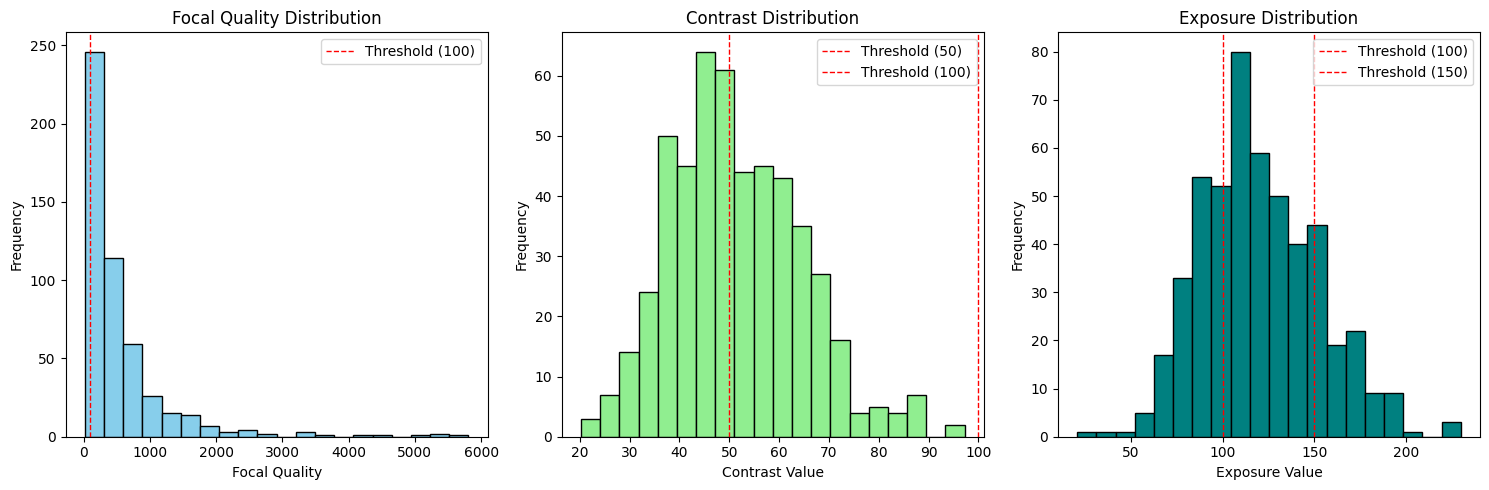

In [10]:
# plot histograms for focal, contrast, and exposure
plt.figure(figsize=(15, 5)) 
plt.subplot(1, 3, 1)  # 1 row, 3 columns
plt.hist(df_nabirds['Focal'], bins=20, color='skyblue', edgecolor='black')
plt.title('Focal Quality Distribution')
plt.xlabel('Focal Quality')
plt.ylabel('Frequency')
plt.axvline(100, color='red', linestyle='dashed', linewidth=1, label='Threshold (100)') # Threshold line
plt.legend()


plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
plt.hist(df_nabirds['Contrast'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Contrast Distribution')
plt.xlabel('Contrast Value')
plt.ylabel('Frequency')
plt.axvline(50, color='red', linestyle='dashed', linewidth=1, label='Threshold (50)')
plt.axvline(100, color='red', linestyle='dashed', linewidth=1, label='Threshold (100)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
plt.hist(df_nabirds['Exposure'], bins=20, color='teal', edgecolor='black')
plt.title('Exposure Distribution')
plt.xlabel('Exposure Value')
plt.ylabel('Frequency')
plt.axvline(100, color='red', linestyle='dashed', linewidth=1, label='Threshold (100)')
plt.axvline(150, color='red', linestyle='dashed', linewidth=1, label='Threshold (150)')
plt.legend()

plt.tight_layout()  
plt.show()


In [11]:
# contrast and exposure are not strongly correlated at .46, but there is a correlation
correlation = df_nabirds['Contrast Quality'].corr(df_nabirds['Exposure Quality'])
print(f'Correlation between Contrast and Exposure Quality for August: {correlation}')

Correlation between Contrast and Exposure Quality for August: -0.04659460082181288


In [12]:
# what if we drop poor exposure quality 
df_filtered = df_nabirds[df_nabirds['Exposure Quality'] != False] 
total_remaining = len(df_filtered)
print(f'Images remaining from total sample without Exposure issues {total_remaining}')

contrast_false_remaining = len(df_filtered[df_filtered['Contrast Quality'] == False])
print(f'Images remaining from total sample without Exposure issues and with Contrast issues {contrast_false_remaining}')

percentage = (contrast_false_remaining / total_remaining) * 100
print(f'Percentage of remaining rows with Contrast Quality False: {percentage:.2f}%')


Images remaining from total sample without Exposure issues 276
Images remaining from total sample without Exposure issues and with Contrast issues 146
Percentage of remaining rows with Contrast Quality False: 52.90%
